## <span style="color:#ff5f27">🧬 Train Retrieval Model </span>


In [2]:
!pip install tensorflow==2.15 --quiet
!pip install tensorflow-recommenders==0.7.3 --quiet


## <span style="color:#ff5f27">📝 Imports </span>


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Normalization
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import hopsworks
import warnings
import re
warnings.filterwarnings('ignore')

2025-04-01 23:26:02.576825: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 23:26:02.640107: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 23:26:03.166519: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 23:26:03.166585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 23:26:03.241226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## <span style="color:#ff5f27">🔮 Connect to Hopsworks Feature Store </span>

In [2]:

# Connect to Hopsworks Feature Store
project = hopsworks.login()
fs = project.get_feature_store()



2025-04-01 23:26:12,222 INFO: Initializing external client
2025-04-01 23:26:12,224 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-04-01 23:26:14,102 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


---

## <span style="color:#ff5f27">🔪 Feature Selection </span>


In [67]:
import tensorflow as tf
import pandas as pd

# Load from Hopsworks feature groups
users_fg = fs.get_feature_group(name="users", version=1)
events_fg = fs.get_feature_group(name="events", version=1)
interactions_fg = fs.get_feature_group(name="interactions", version=1)


In [68]:

# Define features for query and candidate towers (retrieval model only)
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_type", "event_city"]


In [69]:

# Join user + event features with interactions
selected_features = interactions_fg.select(["interaction_id"])\
    .join(users_fg.select(QUERY_FEATURES), on="user_id")\
    .join(events_fg.select(CANDIDATE_FEATURES), on="event_id")


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [70]:

# Create feature view
feature_view = fs.create_feature_view(
    name='event_retrieval_2',
    version=1,
    query=selected_features,
)


Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1220788/fs/1208418/fv/event_retrieval_2/version/1


## <span style="color:#ff5f27">🏋️ Training Dataset </span>


In [71]:

# Split dataset
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.01,
    description='Event retrieval dataset splits',
)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.91s) 


In [72]:

# Build tf.data.Dataset
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({col: df[col].values for col in df.columns})

BATCH_SIZE = 1024
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).cache().shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()

# Prepare vocabulary lists for Lookup & Embedding layers
user_id_list = train_df["user_id"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
user_city_list = train_df["user_city"].unique().tolist()
event_city_list = train_df["event_city"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()
user_interest_list = train_df["user_interests"].unique().tolist()

# Print summary
print(f"✅ Training set size: {len(train_df)}")
print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")


✅ Training set size: 147551
📌 Unique Users: 24971, Events: 15410


## <span style="color:#ff5f27">🏰 Two Tower Model </span>


In [97]:
# Recreate your retrieval model in the structure you specified, using your naming conventions and architecture
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict

EMBED_DIM = 32
BATCH_SIZE = 128


# Query Tower
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(len(user_id_list) + 1, self.emb_dim)
        ])

        self.normalized_age = tf.keras.layers.Normalization(axis=None)

        self.city_tokenizer = tf.keras.layers.StringLookup(vocabulary=user_city_list, mask_token=None)

        self.interest_vectorizer = tf.keras.layers.TextVectorization(output_mode="int", max_tokens=100)
        self.interest_embedding = tf.keras.layers.Embedding(input_dim=100, output_dim=self.emb_dim)

        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(self.emb_dim)
        ])

    def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
        city_embedding = tf.one_hot(self.city_tokenizer(inputs["user_city"]), len(user_city_list))
        interests_encoded = self.interest_vectorizer(inputs["user_interests"])
        interests_embedding = self.interest_embedding(interests_encoded)
        pooled_interests = tf.reduce_mean(interests_embedding, axis=1)

        combined = tf.concat([
            self.user_embedding(inputs["user_id"]),
            tf.reshape(self.normalized_age(inputs["age"]), (-1, 1)),
            city_embedding,
            pooled_interests
        ], axis=1)

        return self.fnn(combined)

#query_model = QueryTower()

# Item Tower
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(len(event_id_list) + 1, self.emb_dim)
        ])

        self.type_tokenizer = tf.keras.layers.StringLookup(vocabulary=event_type_list, mask_token=None)
        self.city_tokenizer = tf.keras.layers.StringLookup(vocabulary=event_city_list, mask_token=None)

        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(self.emb_dim)
        ])

    def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
        type_embedding = tf.one_hot(self.type_tokenizer(inputs["event_type"]), len(event_type_list))
        city_embedding = tf.one_hot(self.city_tokenizer(inputs["event_city"]), len(event_city_list))

        combined = tf.concat([
            self.event_embedding(inputs["event_id"]),
            type_embedding,
            city_embedding
        ], axis=1)

        return self.fnn(combined)


# Final Two-Tower Model
class TwoTowerModel(tf.keras.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=item_ds.batch(BATCH_SIZE).map(self.item_model)
            )
        )

    def train_step(self, batch) -> tf.Tensor:
        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

            # Loss computation.
            user_embeddings = self.query_model(batch)
            item_embeddings = self.item_model(batch)
            loss = self.task(
                user_embeddings, 
                item_embeddings,
                compute_metrics=False,
            )

            # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {
            "loss": loss,
            "regularization_loss": regularization_loss,
            "total_loss": total_loss
        }

        return metrics

    def test_step(self, batch) -> tf.Tensor:
        # Loss computation.
        user_embeddings = self.query_model(batch)
        item_embeddings = self.item_model(batch)

        loss = self.task(
            user_embeddings, 
            item_embeddings,
            compute_metrics=True,
        )

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

In [78]:
item_model = ItemTower()

item_df = train_df[CANDIDATE_FEATURES]
item_df.drop_duplicates(subset="event_id", inplace=True)
item_ds = df_to_ds(item_df)

item_model(next(iter(item_ds.batch(1))))

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.1034378 ,  0.25307837, -0.02409855, -0.21434215, -0.20865884,
         0.2825107 ,  0.08243534, -0.19080871,  0.03621292, -0.00299376,
        -0.32388464, -0.01616943,  0.11034765,  0.12019622, -0.03785481,
         0.03032874, -0.18802792, -0.03844262, -0.05466557,  0.14415693,
         0.00334333, -0.3385182 ,  0.31133667, -0.10497378,  0.06360751,
        -0.1534803 ,  0.08513546, -0.1893036 ,  0.05214433,  0.09868944,
        -0.0189276 ,  0.04551537]], dtype=float32)>

In [104]:
query_model = QueryTower()

query_model.normalized_age.adapt(train_ds.map(lambda x : x["age"]))
query_model.interest_vectorizer.adapt(train_ds.map(lambda x: x["user_interests"]))
# Initialize model with inputs.
query_df = train_df[QUERY_FEATURES]
query_ds = df_to_ds(query_df).batch(1)
query_model(next(iter(query_ds)))

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.09916928,  0.10376639,  0.17763008, -0.29964906,  0.02231292,
        -0.07035173,  0.0673886 , -0.26655972,  0.02163243,  0.20003295,
        -0.00768734, -0.19744526,  0.02012715, -0.16231075, -0.0051355 ,
        -0.11004178, -0.0171076 , -0.05376303, -0.01016697,  0.02475424,
         0.07592998, -0.10889281, -0.08541963,  0.08474737, -0.08551901,
         0.05820473, -0.15599851, -0.11633031,  0.17841007, -0.19902197,
         0.00108123, -0.07105935]], dtype=float32)>

In [99]:
# Create a TwoTowerModel with the specified query_model and item_model
model = TwoTowerModel(query_model, item_model)

# Define an optimizer using AdamW with a learning rate of 0.01
optimizer = tf.keras.optimizers.AdamW(
    weight_decay=0.001, 
    learning_rate=0.01,
)

# Compile the model using the specified optimizer
model.compile(optimizer=optimizer)

# Train the model
early_stop = EarlyStopping(
    monitor="val_factorized_top_k/top_10_categorical_accuracy",
    mode="max",
    patience=10,
    restore_best_weights=True
)
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    callbacks=[early_stop], 
                    epochs=10)

# Evaluate final performance
eval_results = model.evaluate(
    val_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")

Epoch 1/10
145/145 [==============================] - 13s 84ms/step - loss: 4767.0074 - regularization_loss: 0.0000e+00 - total_loss: 4767.0074 - val_factorized_top_k/top_1_categorical_accuracy: 0.0160 - val_factorized_top_k/top_5_categorical_accuracy: 0.0434 - val_factorized_top_k/top_10_categorical_accuracy: 0.0630 - val_factorized_top_k/top_50_categorical_accuracy: 0.1159 - val_factorized_top_k/top_100_categorical_accuracy: 0.2064 - val_loss: 2037.4012 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2037.4012
Epoch 2/10
145/145 [==============================] - 14s 96ms/step - loss: 4724.0985 - regularization_loss: 0.0000e+00 - total_loss: 4724.0985 - val_factorized_top_k/top_1_categorical_accuracy: 0.0265 - val_factorized_top_k/top_5_categorical_accuracy: 0.0519 - val_factorized_top_k/top_10_categorical_accuracy: 0.0731 - val_factorized_top_k/top_50_categorical_accuracy: 0.1282 - val_factorized_top_k/top_100_categorical_accuracy: 0.2330 - val_loss: 2133.1765 - val_regulari

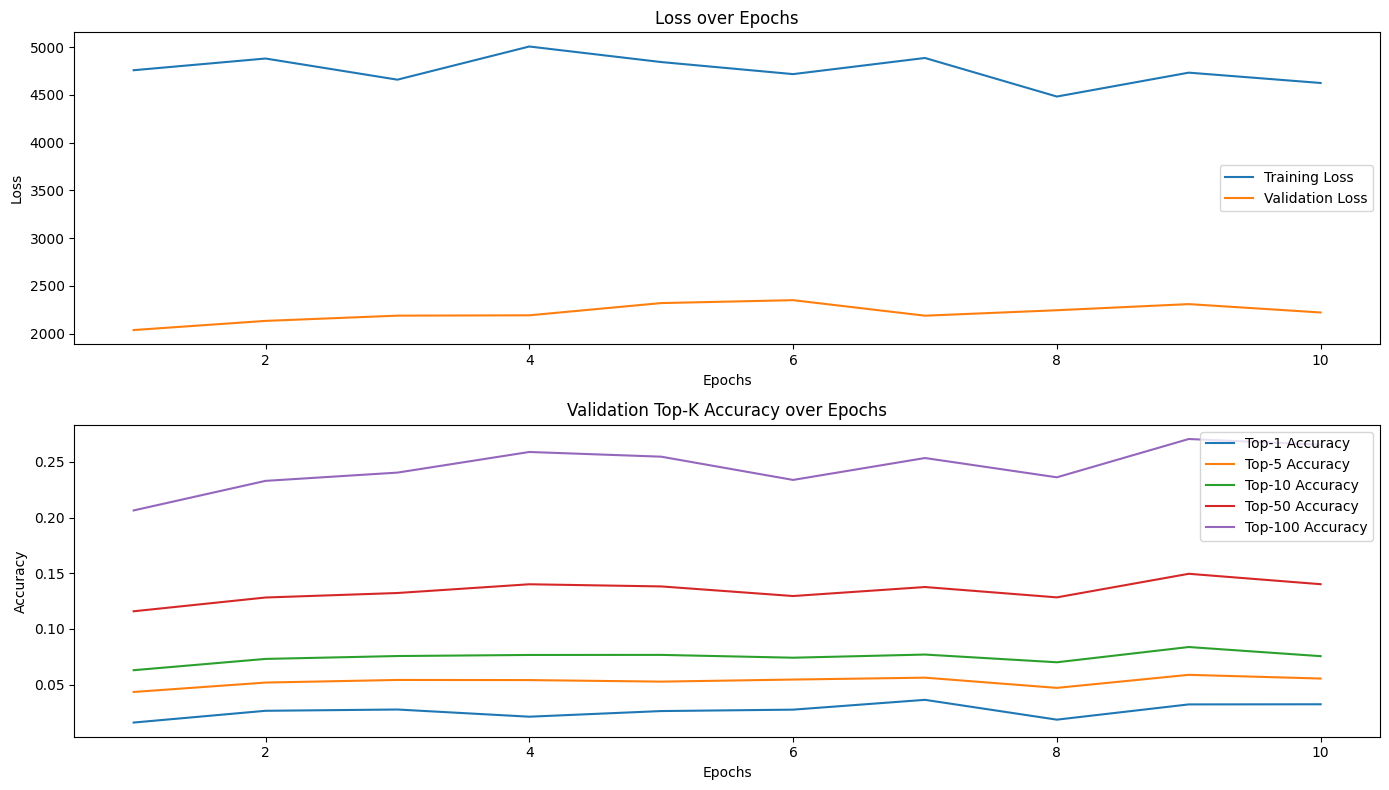

In [101]:
import matplotlib.pyplot as plt


# Plotting function
def plot_metrics(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Top-K Accuracies
    plt.subplot(2, 1, 2)
    for k in [1, 5, 10, 50, 100]:
        metric = f"val_factorized_top_k/top_{k}_categorical_accuracy"
        plt.plot(epochs, history[metric], label=f"Top-{k} Accuracy")

    plt.title("Validation Top-K Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot
#plot_metrics(history)
plot_metrics(history.history)


In [107]:


# Connect to Hopsworks Model Registry
mr = project.get_model_registry()

# Create a wrapper module for the query model
class QueryModelModule(tf.Module):
    def __init__(self, query_model):
        self.query_model = query_model

    @tf.function()
    def compute_emb(self, instances):
        query_emb = self.query_model(instances)
        return {
            "user_id": instances["user_id"],
            "user_city": instances["user_city"],
            "age": instances["age"],
            "user_interests": instances["user_interests"],
            "query_emb": query_emb,
        }

# Wrap query_model
query_model_module = QueryModelModule(model.query_model)


In [108]:

# Define input specifications
instances_spec = {
    'user_id': tf.TensorSpec(shape=(None,), dtype=tf.string),
    'user_city': tf.TensorSpec(shape=(None,), dtype=tf.string),
    'age': tf.TensorSpec(shape=(None,), dtype=tf.int64),
    'user_interests': tf.TensorSpec(shape=(None,), dtype=tf.string),
}

# Get the concrete function
signatures = query_model_module.compute_emb.get_concrete_function(instances_spec)

# Save models to disk
tf.saved_model.save(
    query_model_module,
    "query_model",
    signatures=signatures,
)

tf.saved_model.save(
    model.item_model,
    "candidate_model"
)


2025-04-02 23:22:28,105 INFO: Function `compute_emb` contains input name(s) instances, table_handle, 1943261, 1943271, resource with unsupported characters which will be renamed to instances_3, query_tower_42_sequential_195_string_lookup_268_none_lookup_lookuptablefindv2_table_handle, query_tower_42_embedding_164_embedding_lookup_1943261, query_tower_42_sequential_195_embedding_163_embedding_lookup_1943271, query_tower_42_sequential_196_dense_199_biasadd_readvariableop_resource in the SavedModel.
INFO:tensorflow:Assets written to: query_model/assets
2025-04-02 23:22:37,325 INFO: Assets written to: query_model/assets
INFO:tensorflow:Assets written to: candidate_model/assets
2025-04-02 23:22:40,597 INFO: Assets written to: candidate_model/assets


In [109]:

# Create schemas for Hopsworks
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Query model schema
query_df = train_df[["user_id", "user_city", "age", "user_interests"]]
query_model_input_schema = Schema(query_df)
query_model_output_schema = Schema([{
    "name": "query_embedding",
    "type": "float32",
    "shape": [EMBED_DIM],
}])

query_model_schema = ModelSchema(
    input_schema=query_model_input_schema,
    output_schema=query_model_output_schema,
)

# Sample for example
query_example = query_df.sample().to_dict("records")


In [110]:

# Create and save query model in registry
mr_query_model = mr.tensorflow.create_model(
    name="query_model",
    description="Model that generates query embeddings from user features for event recommendation",
    input_example=query_example,
    model_schema=query_model_schema,
)
mr_query_model.save("query_model")

# Candidate model schema
item_model_input_schema = Schema(item_df)
item_model_output_schema = Schema([{
    "name": "candidate_embedding",
    "type": "float32",
    "shape": [EMBED_DIM],
}])

candidate_model_schema = ModelSchema(
    input_schema=item_model_input_schema,
    output_schema=item_model_output_schema,
)


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/58 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/635554 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/756 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/3230722 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/97 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/494 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1220788/models/query_model/1


In [111]:

# Sample for example
candidate_example = item_df.sample().to_dict("records")

# Create and save candidate model in registry
mr_candidate_model = mr.tensorflow.create_model(
    name="candidate_model",
    description="Model that generates candidate embeddings from event features",
    input_example=candidate_example,
    model_schema=candidate_model_schema,
)
mr_candidate_model.save("candidate_model")


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/58 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/349583 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/425 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1989173 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/79 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/432 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1220788/models/candidate_model/1


Model(name: 'candidate_model', version: 1)

: 